In [1]:
# examinations of the all-sky error table for AMSUA/ATMS
# initial built: ?
# modified: (modified from nonGaussian_omf_analysis.ipynb) at 2024/10/09
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from matplotlib import colors   # <-- import colors from matplotlib


In [1174]:
instrument = 'amsua'
channel    = 'ch15'
expname    = 'v3_hydro'
sdate      = '2024070500'
edate      = '2024073012'

In [1175]:
root = '/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/csv_files/'
#fn = f'{root}/{expname}/omf_stats_{instrument}_{channel}_{sdate}_{edate}.csv'
fn = f'{root}/{expname}/omfges_stats_{instrument}_{channel}_{sdate}_{edate}.csv'
df = pd.read_csv(fn)

In [1176]:
df.info()
#df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963739 entries, 0 to 963738
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sensor         963739 non-null  object 
 1   Unnamed: 1     963739 non-null  int64  
 2   lat            963739 non-null  float64
 3   lon            963739 non-null  float64
 4   fwater         963739 non-null  float64
 5   fland          963739 non-null  float64
 6   obs            963739 non-null  float64
 7   clw_obs        963739 non-null  float64
 8   cldeff_obs     963739 non-null  float64
 9   cld_ch3_obs    963739 non-null  float64
 10  cld_lwpsi_obs  963739 non-null  float64
 11  si_1_15_obs    963739 non-null  float64
 12  si_1_2_15_obs  963739 non-null  float64
 13  clw_bg         963739 non-null  float64
 14  cldeff_bg      963739 non-null  float64
 15  cld_ch3_bg     963739 non-null  float64
 16  cld_lwpsi_bg   963739 non-null  float64
 17  si_1_15_bg     963739 non-nul

In [1177]:
# screen the data:
#dfs = df[abs(df['omf_ges']) < 1e3]
dfs = df[abs(df['omf']) < 1e3]

In [1178]:
# sort the data based on regions

#regions=['land','sea']
#lats   =['Global','90S-60S','60S-40S','40S-20S','20S-0','0-20N','20N-40N','40N-60N','60N-90N']

regions = ['sea']
lats    = ['Global']

adf={} # "a"nalysis "d"ata "f"rame
adf_no_conv={} # without convection

for rg in regions:
    adf[rg] = {}  # Initialize the nested dictionary for each experiment
    adf_no_conv[rg] = {}  # Initialize the nested dictionary for each experiment
    
    if rg == 'land':
        dftmp = dfs.loc[ dfs['fland']>=0.99 ]
    elif rg == 'sea':
        dftmp = dfs.loc[ dfs['fwater']>=0.99 ]
        
    for lat in lats:
        if lat == 'Global':
            adf[rg][lat] = dftmp
            adf_no_conv[rg][lat] = dftmp.loc[ dftmp['qcmark'] <= 3]
            
        elif lat == '90S-60S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-60) & (dftmp['lat']>-90) ]
        elif lat == '60S-40S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-40) & (dftmp['lat']>-60) ]
        elif lat == '40S-20S':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=-20) & (dftmp['lat']>-40) ]
        elif lat == '20S-0':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=0) & (dftmp['lat']>-20) ]
        elif lat == '0-20N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=20) & (dftmp['lat']>0) ]
        elif lat == '20N-40N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=40) & (dftmp['lat']>20) ]
        elif lat == '40N-60N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=60) & (dftmp['lat']>40) ]
        elif lat == '60N-90N':
            adf[rg][lat] = dftmp.loc[ (dftmp['lat']<=90) & (dftmp['lat']>60) ]

In [1179]:
adf['sea']['Global']['qcmark'].describe()

count    963739.000000
mean          5.749372
std          16.444319
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          53.000000
Name: qcmark, dtype: float64

In [1188]:
# Mapping from instrument → channel group → cld_pred value
cld_mapping = {
    'amsua': {
        ('ch1', 'ch2', 'ch3'): 'clw',
        ('ch4', 'ch5','ch15'): 'ch3',
    },
    'atms': {
        ('ch1', 'ch2', 'ch3'): 'clw',
        ('ch4', 'ch5', 'ch6','ch16','ch17'): 'ch3',
        ('ch18','ch19', 'ch20', 'ch21','ch22'): 'si1617',
    }
}

def get_cld_pred(instrument, channel):
    if instrument not in cld_mapping:
        raise ValueError(f"Unknown instrument '{instrument}'")
    for chans, value in cld_mapping[instrument].items():
        if channel in chans:
            return value
            
    raise ValueError(f"Unknown channel {channel} in {instrument}")
'''
# Example usage
test_instr = 'amsua'
test_ch    = 'ch15'

test_cld_pred = get_cld_pred(test_instr, test_ch)
print(f"cloud predictor for {test_instr} {test_ch} is {test_cld_pred}")
'''

'\n# Example usage\ntest_instr = \'amsua\'\ntest_ch    = \'ch15\'\n\ntest_cld_pred = get_cld_pred(test_instr, test_ch)\nprint(f"cloud predictor for {test_instr} {test_ch} is {test_cld_pred}")\n'

In [1189]:
###
# symmetric cloud error bins (cautious! this block runs slow)
###

cld_pred = get_cld_pred(instrument, channel)

if cld_pred == 'clw':
    cloud_range = np.linspace(0,1,51)
elif cld_pred == 'ch3':
    cloud_range = np.linspace(0,30,51)
elif cld_pred == 'si1617':
    cloud_range = np.linspace(0,50,51)

clddic={}; # cloud dictionary
clddic_nc={}; # no convection
for lat in lats:
    print('now processing', lat)

    clddic[lat]={}; # initialize the nested dictionary
    clddic_nc[lat]={}; # initialize the nested dictionary

    cld_list=[];    mean_list=[];    stdev_list=[];    ct_list=[];
    cld_list_nc=[]; mean_list_nc=[]; stdev_list_nc=[]; ct_list_nc=[];

    for i, c in enumerate(cloud_range[:-1]):
        if np.mod(i,5)==0: 
            print(i)

        if cld_pred == 'clw':
            dftmp         = adf['sea'][lat]
            clddf = dftmp['omf'].loc[ (0.5*(dftmp['clw_obs'] + dftmp['clw_bg'])>= cloud_range[i]  ) & \
                                      (0.5*(dftmp['clw_obs'] + dftmp['clw_bg'])<  cloud_range[i+1]) ]
            cld_list.append(0.5*(cloud_range[i] + cloud_range[i+1]))
            ct_list.append(clddf.shape[0])
            mean_list.append(clddf.mean())
            stdev_list.append(clddf.std())

            dftmp         = adf_no_conv['sea'][lat]
            clddf = dftmp['omf'].loc[ (0.5*(dftmp['clw_obs'] + dftmp['clw_bg'])>= cloud_range[i]  ) & \
                                      (0.5*(dftmp['clw_obs'] + dftmp['clw_bg'])<  cloud_range[i+1]) ]
            cld_list_nc.append(0.5*(cloud_range[i] + cloud_range[i+1]))
            ct_list_nc.append(clddf.shape[0])
            mean_list_nc.append(clddf.mean())
            stdev_list_nc.append(clddf.std())
            
        elif cld_pred == 'ch3':
            dftmp         = adf['sea'][lat]
            clddf = dftmp['omf'].loc[ (0.5*(dftmp['cld_ch3_obs'] + dftmp['cld_ch3_bg'])>= cloud_range[i]  ) & \
                                      (0.5*(dftmp['cld_ch3_obs'] + dftmp['cld_ch3_bg'])<  cloud_range[i+1]) ]
            cld_list.append(0.5*(cloud_range[i] + cloud_range[i+1]))
            ct_list.append(clddf.shape[0])
            mean_list.append(clddf.mean())
            stdev_list.append(clddf.std())

            dftmp         = adf_no_conv['sea'][lat]
            clddf = dftmp['omf'].loc[ (0.5*(dftmp['cld_ch3_obs'] + dftmp['cld_ch3_bg'])>= cloud_range[i]  ) & \
                                      (0.5*(dftmp['cld_ch3_obs'] + dftmp['cld_ch3_bg'])<  cloud_range[i+1]) ]
            cld_list_nc.append(0.5*(cloud_range[i] + cloud_range[i+1]))
            ct_list_nc.append(clddf.shape[0])
            mean_list_nc.append(clddf.mean())
            stdev_list_nc.append(clddf.std())            
            
        elif cld_pred == 'si1617':
            dftmp         = adf['sea'][lat]
            clddf = dftmp['omf'].loc[ np.abs( (0.5*(dftmp['si_16_17_obs'] + dftmp['si_16_17_bg']))>= cloud_range[i]  ) & \
                                      np.abs( (0.5*(dftmp['si_16_17_obs'] + dftmp['si_16_17_bg']))<  cloud_range[i+1]) ]
            cld_list.append(0.5*(cloud_range[i] + cloud_range[i+1]))
            ct_list.append(clddf.shape[0])
            mean_list.append(clddf.mean())
            stdev_list.append(clddf.std())

            dftmp         = adf_no_conv['sea'][lat]
            clddf = dftmp['omf'].loc[ (0.5*(dftmp['si_16_17_obs'] + dftmp['si_16_17_bg'])>= cloud_range[i]  ) & \
                                      (0.5*(dftmp['si_16_17_obs'] + dftmp['si_16_17_bg'])<  cloud_range[i+1]) ]
            cld_list_nc.append(0.5*(cloud_range[i] + cloud_range[i+1]))
            ct_list_nc.append(clddf.shape[0])
            mean_list_nc.append(clddf.mean())
            stdev_list_nc.append(clddf.std())   
            
            
    clddic[lat]['cloud_bin']= cld_list
    clddic[lat]['count']    = ct_list
    clddic[lat]['mean']     = mean_list
    clddic[lat]['stdev']    = stdev_list

    clddic_nc[lat]['cloud_bin']= cld_list_nc
    clddic_nc[lat]['count']    = ct_list_nc
    clddic_nc[lat]['mean']     = mean_list_nc
    clddic_nc[lat]['stdev']    = stdev_list_nc

now processing Global
0
5
10
15
20
25
30
35
40
45


In [1190]:
cld_pred

'ch3'

In [1191]:
# parameters for the piecewise linear fit

err_params = {};
#versions = ['default', 'v0', 'v1','hydro']
versions = ['hydro','hydro_cv']


if instrument == 'amsua':
    if channel == 'ch1':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.05, 0.60, 2.50, 20.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 2.30,  7.50]) # first-time estimate
            err_params['v1']      = np.array([0.03, 0.25, 2.30,  7.50]) # second-time estimate
            err_params['hydro']   = np.array([0.03, 0.50, 2.30, 16.50]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.60, 2.30, 19.50]) # with hydro & allow deep convection
    elif channel == 'ch2':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.45, 2.20, 18.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 1.90, 12.00])
            err_params['v1']      = np.array([0.03, 0.28, 1.90, 12.30])
            err_params['hydro']   = np.array([0.03, 0.45, 1.90, 22.50]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.60, 1.90, 32.50]) # with hydro & allow deep convection
    elif channel == 'ch3':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.40, 2.00, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 1.50,  7.30]) 
            err_params['v1']      = np.array([0.03, 0.28, 1.50,  7.30])
            err_params['hydro']   = np.array([0.03, 0.35, 1.50,  9.00]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.35, 1.50,  9.00]) # with hydro
    elif channel == 'ch4':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.02, 0.45, 0.60,  3.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 0.34,  1.22])   
            err_params['v1']      = np.array([0.03, 0.27, 0.34,  1.22])
            err_params['hydro']   = np.array([0.03, 0.40, 0.50,  1.80]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.80, 0.50,  3.50]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.5, 10, 0.5, 1.6]) # with hydro
            err_params['hydro_cv']= np.array([0.5, 10, 0.5, 1.9]) # with hydro            
    elif channel == 'ch5':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.00, 1.00, 0.30,  0.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.40, 0.19,  0.38]) 
            err_params['v1']      = np.array([0.03, 0.37, 0.19,  0.40]) 
            err_params['hydro']   = np.array([0.03, 0.37, 0.19,  0.40]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.85, 0.19,  2.50]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.5, 10, 0.19,  0.35]) # with hydro
            err_params['hydro_cv']= np.array([0.5, 10, 0.22,  1.20]) # with hydro            
    elif channel == 'ch15':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.20, 3.50, 18.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.25, 3.40,  9.50])        
            err_params['v1']      = np.array([0.02, 0.22, 3.40,  9.80])
            err_params['hydro']   = np.array([0.01, 0.22, 2.8,  9.8]) # with hydro
            err_params['hydro_cv']= np.array([0.01, 0.22, 2.8,  9.8]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.2, 5.5, 2.2, 9.8]) # with hydro
            err_params['hydro_cv']= np.array([0.2, 5.5, 2.2, 9.8]) # with hydro            

elif instrument == 'atms':
    if channel == 'ch1':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.35, 4.50, 20.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 2.10,  8.60])
            err_params['v1']      = np.array([0.03, 0.30, 2.10,  8.60])
            err_params['hydro']   = np.array([0.03, 0.35, 2.10, 14.50]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.60, 2.10, 18.50]) # with hydro            
    elif channel == 'ch2':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.38, 4.50, 25.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 1.50, 15.80])
            err_params['v1']      = np.array([0.03, 0.36, 1.90, 15.80])
            err_params['hydro']   = np.array([0.03, 0.36, 1.90, 20.00]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.50, 1.90, 27.50]) # with hydro
    elif channel == 'ch3':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.40, 4.50, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 1.30,  8.30])
            err_params['v1']      = np.array([0.03, 0.30, 1.50,  8.30])
            err_params['hydro']   = np.array([0.03, 0.35, 1.50, 10.50]) # with hydro    
            err_params['hydro_cv']= np.array([0.03, 0.35, 1.50, 10.50]) # with hydro       
    elif channel == 'ch4':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.02, 0.45, 2.50,  7.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 0.80,  4.40])
            err_params['v1']      = np.array([0.03, 0.30, 0.90,  4.50])
            err_params['hydro']   = np.array([0.03, 0.35, 0.90,  6.25]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.30, 0.90,  5.00]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.5, 11,   0.9, 5.0]) # with hydro
            err_params['hydro_cv']= np.array([0.5, 12.5, 0.9, 5.6]) # with hydro            
    elif channel == 'ch5':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.50, 0.55,  3.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 0.29,  1.40])
            err_params['v1']      = np.array([0.03, 0.30, 0.31,  1.42]) 
            err_params['hydro']   = np.array([0.03, 0.35, 0.31,  2.00]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.45, 0.31,  2.50]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.5, 10, 0.3, 1.6]) # with hydro
            err_params['hydro_cv']= np.array([0.5, 10, 0.3, 1.8]) # with hydro         
    elif channel == 'ch6':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.08, 1.00, 0.30,  3.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.45, 0.14,  0.62])
            err_params['v1']      = np.array([0.03, 0.40, 0.14,  0.62])
            err_params['hydro']   = np.array([0.03, 0.40, 0.14,  0.45]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.75, 0.14,  1.75]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.5, 12.5, 0.14,  0.45]) # with hydro
            err_params['hydro_cv']= np.array([0.5, 12.5, 0.16,  1.00]) # with hydro
    elif channel == 'ch16':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.02, 0.35, 4.00, 19.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.35, 2.90, 11.00])  
            err_params['v1']      = np.array([0.01, 0.26, 3.00, 11.00]) 
            err_params['hydro']   = np.array([0.01, 0.26, 3.00, 11.00]) # with hydro
            err_params['hydro_cv']= np.array([0.01, 0.26, 3.00, 11.00]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.2, 4.5, 2.2, 9.8]) # with hydro
            err_params['hydro_cv']= np.array([0.2, 4.5, 2.2, 9.8]) # with hydro
    elif channel == 'ch17':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.50, 4.00, 30.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.30, 1.50,  5.30])   
            err_params['v1']      = np.array([0.03, 0.20, 1.50,  5.30])
            err_params['hydro']   = np.array([0.03, 0.40, 1.50,  8.00]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.60, 1.50, 24.50]) # with hydro
        elif cld_pred == 'ch3':
            err_params['hydro']   = np.array([0.5, 12.5, 1.50,  8.50]) # with hydro
            err_params['hydro_cv']= np.array([0.5, 10, 2.30, 14.00]) # with hydro
    elif channel == 'ch18':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.50, 3.50, 25.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.45, 1.14,  2.42])   
            err_params['v1']      = np.array([0.03, 0.40, 1.28,  2.80])
            err_params['hydro']   = np.array([0.03, 0.40, 1.28,  4.50]) # with hydro
            err_params['hydro_cv']= np.array([0.03, 0.60, 1.28, 17.50]) # with hydro
        elif cld_pred == 'si1617':
            err_params['hydro']   = np.array([1, 15, 1.28,  4.50]) # with hydro
            err_params['hydro_cv']= np.array([1, 30, 1.28, 15.00]) # with hydro            
    elif channel == 'ch19':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.50, 3.00, 16.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.55, 1.17,  3.10])   
            err_params['v1']      = np.array([0.02, 0.55, 1.20,  3.30])
            err_params['hydro']   = np.array([0.02, 0.55, 1.20,  3.30]) # with hydro 
            err_params['hydro_cv']= np.array([0.02, 0.55, 1.20, 12.50]) # with hydro 
        elif cld_pred == 'si1617':
            err_params['hydro']   = np.array([1, 20, 1.20,  4.50]) # with hydro
            err_params['hydro_cv']= np.array([1, 30, 1.20, 10.50]) # with hydro              
    elif channel == 'ch20':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.03, 0.50, 3.00, 12.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.55, 1.25,  3.53])   
            err_params['v1']      = np.array([0.03, 0.55, 1.25,  3.53])
            err_params['hydro']   = np.array([0.03, 0.55, 1.25,  3.53])
            err_params['hydro_cv']= np.array([0.03, 0.55, 1.25,  8.50])
        elif cld_pred == 'si1617':
            err_params['hydro']   = np.array([1, 20, 1.25,  3.00])
            err_params['hydro_cv']= np.array([1, 25, 1.25,  7.00])            
    elif channel == 'ch21':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.05, 0.50, 3.00,  9.00]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.55, 1.37,  3.98])   
            err_params['v1']      = np.array([0.03, 0.55, 1.50,  3.98]) 
            err_params['hydro']   = np.array([0.03, 0.40, 1.50,  2.50])
            err_params['hydro_cv']= np.array([0.03, 0.50, 1.50,  5.50])
        elif cld_pred == 'si1617':
            err_params['hydro']   = np.array([1, 20, 1.50,  2.20])
            err_params['hydro_cv']= np.array([1, 30, 1.50,  5.00])            
    elif channel == 'ch22':
        if cld_pred == 'clw':
            err_params['default'] = np.array([0.10, 0.50, 3.00,  6.50]) # clear cloud, cloudy cloud, clear stdev, cloudy stdev
            err_params['v0']      = np.array([0.03, 0.55, 1.50,  4.05])   
            err_params['v1']      = np.array([0.03, 0.55, 1.60,  4.05])
            err_params['hydro']   = np.array([0.03, 0.40, 1.60,  2.50])
            err_params['hydro_cv']= np.array([0.03, 0.55, 1.60,  4.05])
        elif cld_pred == 'si1617':
            err_params['hydro']   = np.array([1, 20, 1.60,  2.20])
            err_params['hydro_cv']= np.array([1, 30, 1.60,  3.50])              


In [1192]:
# construct the piecewise linear model:
num_cloud_bin = len(clddic[lat]['cloud_bin'])
err_model = {};

for version in versions:
    err_model[version] = np.zeros(num_cloud_bin)
    
    for i in range(num_cloud_bin):
        if cloud_range[i] < err_params[version][0]:
            err_model[version][i] = err_params[version][2]
        elif (cloud_range[i] >= err_params[version][0]) & (cloud_range[i] < err_params[version][1]):
            err_model[version][i] = np.interp(cloud_range[i], np.array(err_params[version][0:2]), np.array(err_params[version][2:]))
        elif cloud_range[i] >= err_params[version][1]:
            err_model[version][i] = err_params[version][3]


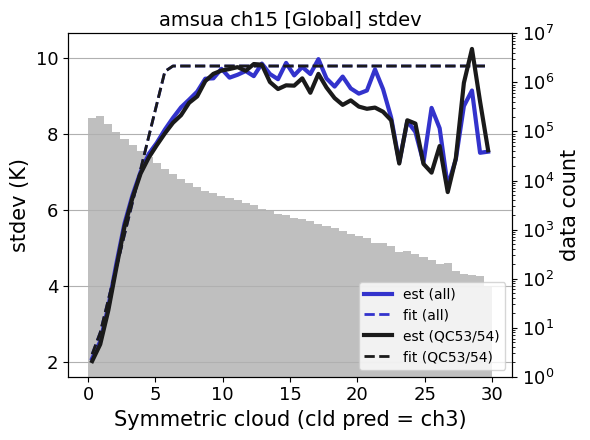

In [1193]:
# plot the stdev errors/data counts

save_fig = True
# not decided yet:
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/tables/{expname}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

bar_width={};
bar_width['clw'] = 0.02
bar_width['ch3'] = 0.60
bar_width['si1617'] = 1.00

for lat in lats:
    fig, ax2 = plt.subplots(figsize=(6,4.5))

    ax2.bar(clddic[lat]['cloud_bin'], clddic[lat]['count'], width=bar_width[cld_pred], color=(0.5, 0.5, 0.5), alpha=0.5)
    ax2.set_xlabel(f'Symmetric cloud (cld pred = {cld_pred})', fontsize=15)
    ax2.set_yscale('log')
    ax2.set_ylim(1,1e7)
    ax2.set_ylabel('data count', fontsize=15)
    ax2.tick_params(axis='both', labelsize=13)

    ax1 = ax2.twinx()
    # move ax2 (bar axis) to the right, ax1 (line axis) to the left
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.tick_left()
    
    ax1.plot(clddic[lat]['cloud_bin'], clddic[lat]['stdev'], color=(0.2, 0.2, 0.8), linewidth=3, label='est (all)')
    ax1.plot(clddic[lat]['cloud_bin'], err_model['hydro_cv'], color=(0.2, 0.2, 0.8), linestyle='--', linewidth=2, label='fit (all)')

    ax1.plot(clddic[lat]['cloud_bin'], clddic_nc[lat]['stdev'], color=(0.1, 0.1, 0.1), linewidth=3, label='est (QC53/54)')
    ax1.plot(clddic[lat]['cloud_bin'], err_model['hydro'], color=(0.1, 0.1, 0.1), linestyle='--', linewidth=2, label='fit (QC53/54)')

    #ax1.plot(clddic[lat]['cloud_bin'], err_model['default'], color=(0.8, 0.3, 0.3), linestyle='--', linewidth=3, label='default table')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v0'], color=(0.3, 0.3, 0.3), linestyle='--', label='SHiELD')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v1'], color=(0, 102/255, 204/255), linestyle='--', label='SHiELD fit-2')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v1'], color=(0, 102/255, 204/255), linestyle='--', linewidth=3, label='SHiELD table w/o hydro')

    #ax1.set_xlabel('Predictor = Symmetric cloud', fontsize=14)
    ax1.set_ylabel('stdev (K)', fontsize=15)
    #ax1.set_xlim(0,10)
    #if instrument == 'amsua':
    #    if channel == ('ch1'):
    #        ax1.set_ylim(0,20)
    #ax1.set_ylim(0,10)
    ax1.grid(True, which='both', axis='both')
    ax1.tick_params(axis='both', labelsize=13)
    ax1.legend(loc='best')

    ax1.set_title(f'{instrument} {channel} [{lat}] stdev', fontsize=14)
    plt.tight_layout()

    if save_fig:
        plt.savefig(f'{fig_dir}/allsky_error_table_{cld_pred}_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')

In [1194]:
clddic[lat]['stdev'][0]

np.float64(2.087811283191491)

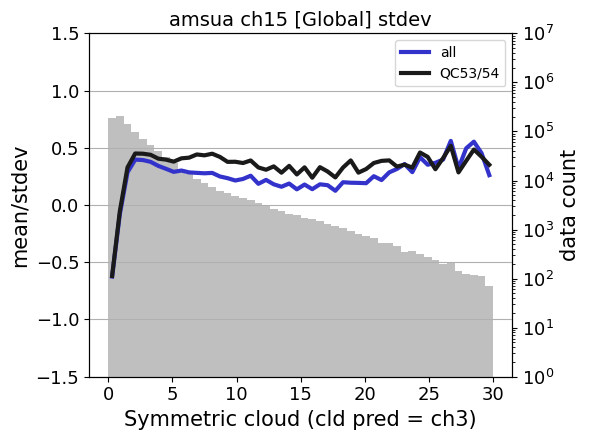

In [1195]:
# plot the mean /data counts

save_fig = True
# not decided yet:
fig_dir = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/tables/{expname}'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print(f"Directory '{fig_dir}' created.")

bar_width={};
bar_width['clw'] = 0.02
bar_width['ch3'] = 0.60
bar_width['si1617'] = 1.00

for lat in lats:
    fig, ax2 = plt.subplots(figsize=(6,4.5))
    ax2.bar(clddic[lat]['cloud_bin'], clddic[lat]['count'], width=bar_width[cld_pred], color=(0.5, 0.5, 0.5), alpha=0.5)
    ax2.set_xlabel(f'Symmetric cloud (cld pred = {cld_pred})', fontsize=15)
    ax2.set_yscale('log')
    ax2.set_ylim(1,1e7)
    ax2.set_ylabel('data count', fontsize=15)
    ax2.tick_params(axis='both', labelsize=13)

    ax1 = ax2.twinx()
    # move ax2 (bar axis) to the right, ax1 (line axis) to the left
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax1.yaxis.set_label_position("left")
    ax1.yaxis.tick_left()
    
    ax1.plot(clddic[lat]['cloud_bin'], np.array(clddic[lat]['mean'])/np.array(clddic[lat]['stdev']), color=(0.2, 0.2, 0.8), linewidth=3, label='all')
    ax1.plot(clddic[lat]['cloud_bin'], np.array(clddic_nc[lat]['mean'])/np.array(clddic_nc[lat]['stdev']), color=(0.1, 0.1, 0.1), linewidth=3, label='QC53/54')

    #ax1.plot(clddic[lat]['cloud_bin'], err_model['default'], color=(0.8, 0.3, 0.3), linestyle='--', linewidth=3, label='default table')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v0'], color=(0.3, 0.3, 0.3), linestyle='--', label='SHiELD')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v1'], color=(0, 102/255, 204/255), linestyle='--', label='SHiELD fit-2')
    #ax1.plot(clddic[lat]['cloud_bin'], err_model['v1'], color=(0, 102/255, 204/255), linestyle='--', linewidth=3, label='SHiELD table w/o hydro')

    #ax1.set_xlabel('Predictor = Symmetric cloud', fontsize=14)
    ax1.set_xlabel(f'Symmetric cloud (cld pred = {cld_pred})', fontsize=15)
    ax1.set_ylabel('mean/stdev', fontsize=15)
    #ax1.set_xlim(0,10)
    #if instrument == 'amsua':
    #    if channel == ('ch1'):
    #        ax1.set_ylim(0,20)
    ax1.set_ylim(-1.5,1.5)
    ax1.grid(True)
    ax1.tick_params(axis='both', labelsize=13)
    ax1.legend(loc='best')
    ax1.set_title(f'{instrument} {channel} [{lat}] stdev', fontsize=14)
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'{fig_dir}/normalized_mean_{cld_pred}_{instrument}_{channel}_{lat}.png', dpi=200, bbox_inches='tight')

In [1196]:
len(clddic[lat]['mean']+clddic[lat]['mean'])

100

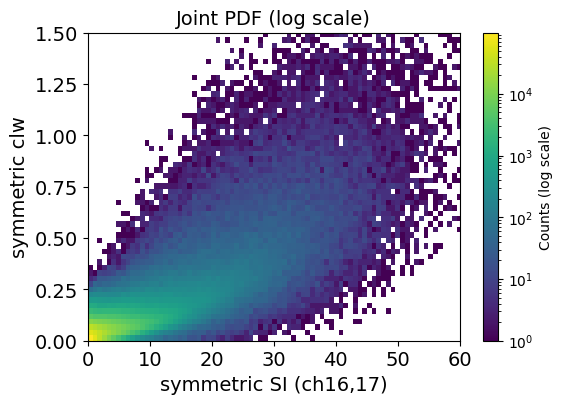

In [792]:
# Plot the joint distribution of cloud predictors (clw vs SI index)
dftmp = adf['sea']['Global']
# Define x and y
x = np.abs(0.5 * (dftmp['si_16_17_obs'] + dftmp['si_16_17_bg']))
y = 0.5 * (dftmp['clw_obs'] + dftmp['clw_bg'])

# 2D histogram (joint PDF)
fig, ax = plt.subplots(figsize=(6,4))

counts, xedges, yedges, im = ax.hist2d(
    x, y, bins=100, norm=colors.LogNorm()
)

fig.colorbar(im, label="Counts (log scale)")
ax.set_xlim([0,60])
ax.set_ylim([0,1.5])
ax.tick_params(axis='both', which='major', labelsize=14) 

ax.set_xlabel("symmetric SI (ch16,17)", fontsize=14)
ax.set_ylabel("symmetric clw", fontsize=14)
ax.set_title("Joint PDF (log scale)", fontsize=14)
if save_fig:
    plt.savefig(f'{fig_dir}/symmetric_clw_vs_si1617.png', dpi=200, bbox_inches='tight')

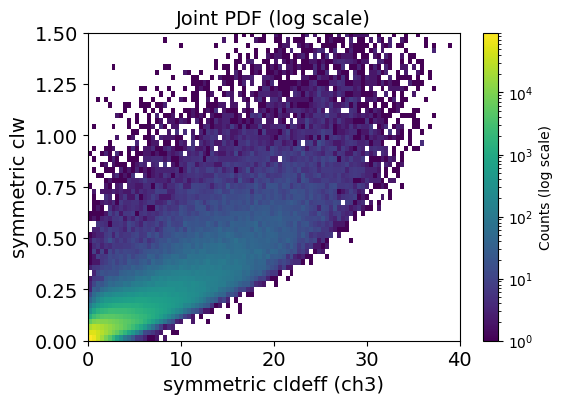

In [793]:
# Plot the joint distribution of cloud predictors (clw vs ch3)
dftmp = adf['sea']['Global']
dftmp = dftmp[(dftmp['cld_ch3_obs'] <= 100) & (dftmp['cld_ch3_bg'] <= 100)] 
# Define x and y
x = 0.5 * (dftmp['cld_ch3_obs'] + dftmp['cld_ch3_bg'])
y = 0.5 * (dftmp['clw_obs'] + dftmp['clw_bg'])

# 2D histogram (joint PDF)
fig, ax = plt.subplots(figsize=(6,4))

counts, xedges, yedges, im = ax.hist2d(
    x, y, bins=100, norm=colors.LogNorm()
)

fig.colorbar(im, label="Counts (log scale)")
ax.set_xlim([0,40])
ax.set_ylim([0,1.5])
ax.tick_params(axis='both', which='major', labelsize=14) 

ax.set_xlabel("symmetric cldeff (ch3)", fontsize=14)
ax.set_ylabel("symmetric clw", fontsize=14)
ax.set_title("Joint PDF (log scale)", fontsize=14)
if save_fig:
    plt.savefig(f'{fig_dir}/symmetric_clw_vs_ch3.png', dpi=200, bbox_inches='tight')

In [783]:
xedges

array([3.7410784e-04, 5.0000000e+08, 1.0000000e+09, 1.5000000e+09,
       2.0000000e+09, 2.5000000e+09, 3.0000000e+09, 3.5000000e+09,
       4.0000000e+09, 4.5000000e+09, 5.0000000e+09, 5.5000000e+09,
       6.0000000e+09, 6.5000000e+09, 7.0000000e+09, 7.5000000e+09,
       8.0000000e+09, 8.5000000e+09, 9.0000000e+09, 9.5000000e+09,
       1.0000000e+10, 1.0500000e+10, 1.1000000e+10, 1.1500000e+10,
       1.2000000e+10, 1.2500000e+10, 1.3000000e+10, 1.3500000e+10,
       1.4000000e+10, 1.4500000e+10, 1.5000000e+10, 1.5500000e+10,
       1.6000000e+10, 1.6500000e+10, 1.7000000e+10, 1.7500000e+10,
       1.8000000e+10, 1.8500000e+10, 1.9000000e+10, 1.9500000e+10,
       2.0000000e+10, 2.0500000e+10, 2.1000000e+10, 2.1500000e+10,
       2.2000000e+10, 2.2500000e+10, 2.3000000e+10, 2.3500000e+10,
       2.4000000e+10, 2.4500000e+10, 2.5000000e+10, 2.5500000e+10,
       2.6000000e+10, 2.6500000e+10, 2.7000000e+10, 2.7500000e+10,
       2.8000000e+10, 2.8500000e+10, 2.9000000e+10, 2.9500000e

(0.0, 50.0)

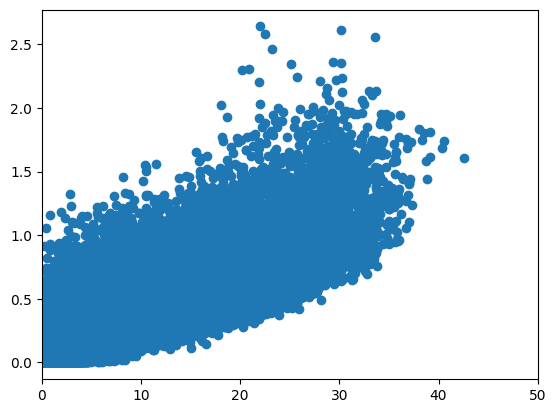

In [781]:
plt.scatter(x,y)
plt.xlim([0,50])

<BarContainer object of 50 artists>

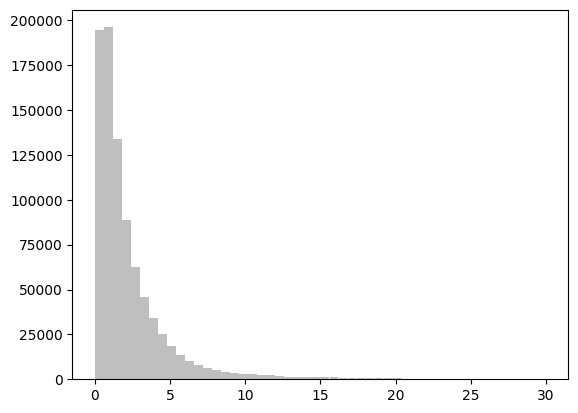

In [100]:
#clddic['Global']['count']
#clddic['Global']['cloud_bin']

#plt.plot(clddic['Global']['cloud_bin'], np.log(clddic['Global']['count']))
plt.bar(clddic[lat]['cloud_bin'], clddic[lat]['count'], width=0.58, color=(0.5, 0.5, 0.5), alpha=0.5)